In [1]:
import sys
sys.path.append("../utils")
import xarray as xr
import numpy as np
import os
from tiff_io import readTiff
from imgShow import imgShow
import matplotlib.pyplot as plt
from coor_convert import geo2imagexy
from osgeo import gdal
import torch
from torchsummary import summary

In [2]:
root_dir = os.path.dirname(os.getcwd())
path_s3l2 = root_dir+'/data/s3a-relative-orbit-260&309/S3A_SR_2_WAT____20190319T133953_20190319T142745_20191218T190703_2872_042_309______MR1_R_NT_004.SEN3/enhanced_measurement_subs_preproc_mainproc_postproc.nc'
path_rsimg = root_dir+'/data/rs_image/greatbay_l8_img.tif'
path_rsimg_wat = root_dir+'/data/rs_image/greatbay_l8_img_wat_sel.tif'
path_model = root_dir + '/results/cnn_1d_improve'


In [3]:
l8_img, im_geotrans, im_proj, im_row, im_col, im_bands = readTiff(path_rsimg)
l8_img_wat,_,_,_,_,_ = readTiff(path_rsimg_wat)
img_gdal = gdal.Open(path_rsimg)
s3_l2 = xr.open_dataset(path_s3l2)
col_fps, row_fps = geo2imagexy(lon=s3_l2['lon_20_ku'], lat=s3_l2['lat_20_ku'],img_gdal=img_gdal)

In [4]:
# tgauge_data
# # cols_fp
s3_l2['dis_fp_tgauge']


<xarray.DataArray 'dis_fp_tgauge' (time_20_ku: 318)>
array([68.887, 68.56 , 68.232, ..., 34.783, 35.11 , 35.436])
Coordinates:
  * time_20_ku  (time_20_ku) datetime64[ns] 2019-03-19T14:08:40.000399104 ......
    lat_20_ku   (time_20_ku) float64 21.7 21.71 21.71 ... 22.61 22.61 22.62
    lon_20_ku   (time_20_ku) float64 114.4 114.4 114.4 ... 114.2 114.2 114.2
Attributes:
    name:     distance between the footprint and tide gauge station
    unit:     kilometer

In [5]:
model = torch.load(path_model)
model.eval()
summary(model, (1,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 128]              64
       BatchNorm1d-2              [-1, 16, 128]              32
            Conv1d-3              [-1, 16, 128]             784
       BatchNorm1d-4              [-1, 16, 128]              32
            Conv1d-5               [-1, 32, 64]           1,568
       BatchNorm1d-6               [-1, 32, 64]              64
            Conv1d-7               [-1, 32, 64]           3,104
       BatchNorm1d-8               [-1, 32, 64]              64
            Conv1d-9               [-1, 64, 32]           6,208
      BatchNorm1d-10               [-1, 64, 32]             128
           Conv1d-11               [-1, 64, 32]          12,352
      BatchNorm1d-12               [-1, 64, 32]             128
           Conv1d-13              [-1, 128, 16]          24,704
      BatchNorm1d-14              [-1, 

In [6]:
wf = s3_l2['waveform_20_ku'].values
wf_nor = [wf[i]/np.max(wf[i]) for i in range(wf.shape[0])] # waveform normalization
wf_nor = torch.unsqueeze(torch.Tensor(wf_nor), 1)
pred = model(wf_nor)
_, pred = torch.max(pred, 1)


In [7]:
s3_l2["wf_cls"] = (['time_20_ku'], pred.numpy())
s3_l2["wf_cls"].attrs['name'] = 'waveform class derived by deep learning model, 1 and 0 represent ocean-like waveform and noisy waveform, respectively.'


In [8]:
s3_l2["wf_cls"]

<xarray.DataArray 'wf_cls' (time_20_ku: 318)>
array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Coordinates:
  * time_20_ku  (time_20_ku) datetime64[ns] 2019-03-19T14:08:40.000399104 ......
    lat_20_ku   (time_20_ku) float64 21.7 21.71 21.71 ... 22.61 22.61 22.62
    lon_20_ku   (time_20_ku) float64 114.4 114.4 114.4 ... 114.2 114.2 114.2
Attributes:
    name:     waveform class derived by deep learning model, 1 and 0 represen...

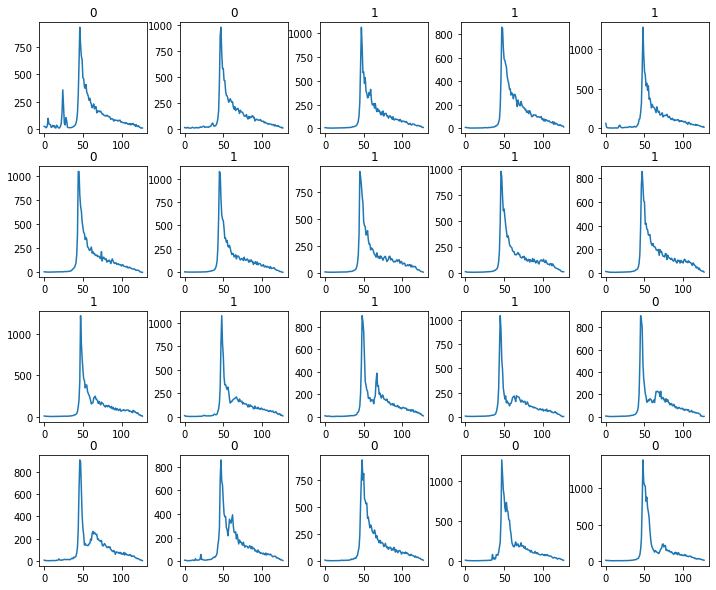

In [25]:
fig = plt.figure(figsize=(12,10))
for i,ind in enumerate(range(150,170)):
    ax = plt.subplot(4,5,i+1)
    ax.plot(s3_l2['waveform_20_ku'][ind,:])
    plt.title(s3_l2["wf_cls"][ind].values)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
